### Hi, Dan! 

Here's a minimaler working example to examine why predictions run separately on two sets of time stamps, where one is the exact subset of the other, lead to different y-values for the corresponding time stamps.

In [1]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import datetime
from numpy.linalg import inv, det, solve, cond

from gaspery import calculate_fi, strategies, utils
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

path = '/Users/chrislam/Desktop/gaspery/'
random = np.random.default_rng(seed=4)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

def mean_function(params, X):
    
    return -params['K'] * jnp.sin(2 * jnp.pi * (X - params['T0']) / params['p'])

### AU Mic b parameters from Klein+ 
K = 8.5
p = 8.46
T0 = 2458651.993 - 2458650
theta = [8.5, 8.46, T0]

Create strategy of observing every other day for 30 total observations

In [2]:
random = np.random.default_rng(seed=4) # formerly seed of 4

n_obs = 30
start = T0
offs = []

strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=1, twice_flag=False)) # off=p-1 :(; off=1.115 :)
print(strat)

[ 1.993  3.993  5.993  7.993  9.993 11.993 13.993 15.993 17.993 19.993
 21.993 23.993 25.993 27.993 29.993 31.993 33.993 35.993 37.993 39.993
 41.993 43.993 45.993 47.993 49.993 51.993 53.993 55.993 57.993 59.993]


Draw training and validation points from a parent plotting grid of n*10 points, where n is the length in days of the observing strategy. The fine grid is built around the observing strategy, so that I can directly select a "training set" comprising the observing strategy from it, as well as a randomized validation set.

In [3]:
# x_fine must pass through strat; this way, I can make it as fine as I want
### build x_fine as evenly spaced 
n = 10
x_fine = np.linspace(strat[0], strat[-1], int((strat[-1] - strat[0]) * n ) + 1)
print(x_fine[2]- x_fine[1])

### concatenate strategy to x_fine
x_fine = np.concatenate((x_fine, strat))
x_fine = np.sort(x_fine)

0.10000000000000009


Star

In [4]:
random = np.random.default_rng(seed=4)

sigma_wn_rv = 5.
sigma_qp_rv = 47. #145 #47
Prot = 4.86
Tau = 110. # 30, 110
eta = 0.37

In [5]:
hyperparams = [sigma_qp_rv, Prot, Tau, eta]
theta = [K, p, T0] 

In [6]:
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

Generate fake ground truth using the strategy, with 30 additional points, to use later for evaluation of overfitting by the MCMC.

In [7]:
random = np.random.default_rng(seed=4)

planet_fine = calculate_fi.model_jax(x_fine, [theta[0], theta[1], theta[2]])
gp_fine = GaussianProcess(kernel, x_fine) 
star_fine = gp_fine.sample(jax.random.PRNGKey(4), shape=(1,)) 
observed_fine = star_fine + planet_fine + random.normal(0, sigma_wn_rv, len(planet_fine))

# assemble parent DataFrame, and split into training and validation sets
df_fine = pd.DataFrame({'x': x_fine, 'y': observed_fine[0], 
                            'planet': planet_fine, 'star': star_fine[0], 
                        'planet-and-star': planet_fine + star_fine[0]})

df_fine = df_fine.drop_duplicates(subset=['x'])

not_injected = df_fine.loc[df_fine.x.isin(strat)]

injected_x = random.choice(x_fine, 30, replace=False)

injected = df_fine.loc[df_fine.x.isin(injected_x)]

What do the training and validation points look like, compared to the model from which they were drawn?

/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_57490/4167762207.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(not_injected.x, not_injected.y, yerr, fmt=".k", capsize=0, color='k', label='strategy')
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_57490/4167762207.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(injected.x, injected.y, yerr, fmt=".k", capsize=0, color='r', label='injected')


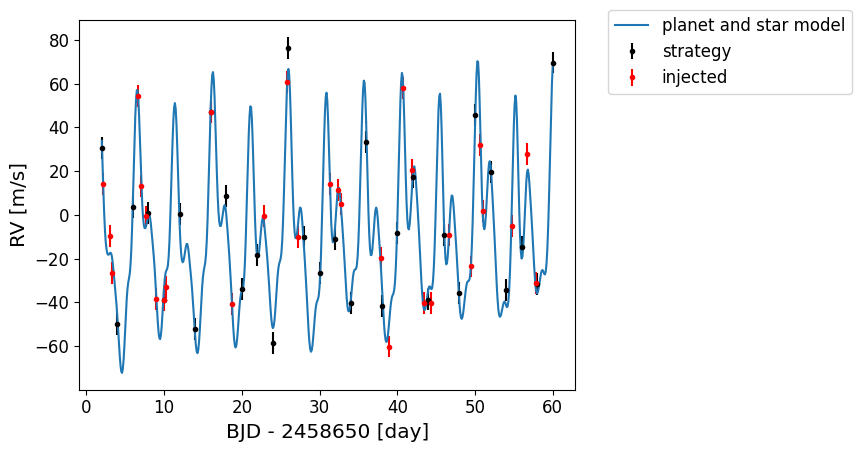

In [8]:
yerr = sigma_wn_rv

plt.errorbar(not_injected.x, not_injected.y, yerr, fmt=".k", capsize=0, color='k', label='strategy')
plt.errorbar(injected.x, injected.y, yerr, fmt=".k", capsize=0, color='r', label='injected')

### also plot the model from which I sample everything. use fine grid, x_fine
plt.plot(x_fine, star_fine[0] + planet_fine, label='planet and star model')
#plt.plot(x_fine, observed_fine[0] - np.median(observed_fine[0]) + np.median(injected_df.y), label='model')

plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")

#plt.xlim([0, 50])
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

#### MCMC sampling

In [9]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def numpyro_model(t, y, yerr, hyperparams, theta, injected_x, not_injected_x, t_fine):        
        
    sigma_qp_rv = hyperparams[0]
    Prot = hyperparams[1]
    Tau = hyperparams[2]
    eta = hyperparams[3]
    
    K = theta[0]
    p = theta[1]
    T0 = theta[2]
 
    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar
    
    # sample hyperparameters for planet mean model
    p = numpyro.sample("P", dist.Normal(p, 0.00004)) 
    K = numpyro.sample("K", dist.TruncatedNormal(10., 5., low=0.)) # formerly K, 2.25, but that's too informative; 4/22/24: why centered at 0, vs 10 m/s?
    #K = numpyro.sample("K", dist.Uniform(0., 100.))
    T0 = numpyro.sample("T0", dist.Normal(T0, 0.0005))
    mean_params = {"K": K, "P": p, "T0": T0}
        
    def mean_function(t):
        """
        Mean model is the planet's Keplerian.
        """

        return -mean_params['K'] * jnp.sin(2 * jnp.pi * (t - mean_params['T0']) / mean_params['P'])
        
    gp = GaussianProcess(kernel, t, diag=yerr**2, mean=mean_function) # mean_function
    #gp_plot = GaussianProcess(kernel, t_plot, diag=yerr**2, mean=mean_function)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    #numpyro.sample("gp_plot", gp_plot.numpyro_dist(), obs=y)

    planet_pred = jax.vmap(gp.mean_function)(t)
    star_pred = gp.condition(y, t, include_mean=False).gp.loc
    numpyro.deterministic("pred", star_pred + planet_pred)
    numpyro.deterministic("pred-star", star_pred)

    planet_pred_plot = jax.vmap(gp.mean_function)(t_fine)
    star_pred_plot = gp.condition(y, t_fine, include_mean=False).gp.loc
    numpyro.deterministic("pred-plot", star_pred_plot + planet_pred_plot)
    numpyro.deterministic("pred-plot-star", star_pred_plot)

    planet_pred_inj = jax.vmap(gp.mean_function)(injected_x)
    star_pred_inj = gp.condition(y, injected_x, include_mean=False).gp.loc
    numpyro.deterministic("inj-rec", star_pred_inj + planet_pred_inj)
    numpyro.deterministic("inj-rec-star", star_pred_inj)

nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000, # 1000
    num_samples=8000, # 5000
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_57490/2291302978.py:57: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


In [10]:
start = datetime.datetime.now()

gp_output = mcmc.run(rng_key, t=np.array(not_injected.x), y=np.array(not_injected.y), yerr=sigma_wn_rv, # X, y vs t_plot, y_plot
         hyperparams=hyperparams, theta=theta, injected_x=np.array(injected.x), 
                     not_injected_x=np.array(not_injected.x), t_fine=x_fine)
samples = mcmc.get_samples()
#print(samples)

preds = samples["pred"].block_until_ready()  # Blocking to get timing right
preds_plot = samples["pred-plot"].block_until_ready()  
preds_star = samples["pred-star"].block_until_ready()  
preds_inj_rec = samples["inj-rec"].block_until_ready()  
preds_plot_star = samples["pred-plot-star"].block_until_ready()  
preds_inj_rec_star = samples["inj-rec-star"].block_until_ready()  
#preds_training_star = samples["training-star"].block_until_ready()  

end = datetime.datetime.now()
print("time elapsed: ", end-start)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:02<00:00, 3012.02it/s, 43 steps of size 1.06e-02. acc. prob=0.96]


time elapsed:  0:00:08.567028


Retrieve posteriors

In [11]:
q = np.percentile(preds, [16, 50, 84], axis=0)
q_plot = np.percentile(preds_plot, [16, 50, 84], axis=0)
q_star = np.percentile(preds_star, [16, 50, 84], axis=0)
q_star_plot = np.percentile(preds_plot_star, [16, 50, 84], axis=0)
q_inj = np.percentile(preds_inj_rec, [16, 50, 84], axis=0)
q_inj_star = np.percentile(preds_inj_rec_star, [16, 50, 84], axis=0)

q_planet = q - q_star # 30
q_planet_plot = q_plot - q_star_plot # 200
q_planet_inj = q_inj - q_inj_star # 20

#### This is where we compare predictions over the fine grid vs just the subset of times constituting the training or validation set.

Grab the validation and training set time stamps from the best-fit model predicted over the fine grid, for uniformity's sake.

In [12]:
fine = pd.DataFrame({'x': x_fine, 'y': q_plot[1], 'star': q_star_plot[2], 'planet': q_planet_plot[1]})
training_inference = fine.loc[fine.x.isin(np.array(not_injected.x))].drop_duplicates(subset=['x'])
validation_inference = fine.loc[fine.x.isin(np.array(injected.x))].drop_duplicates(subset=['x'])

#### Plotting to troubleshoot

q_inj is the prediction from the best-fit model (trained on the 30 observations that comprise the observing strategy), made on just the 30 time stamps comprising the validation set.

q_inj from fine is the prediction from the best-fit model, made on _all_ 600-odd time stamps comprising the fine grid, but only sub-selected for the 30 time stamps comprising the validation set. 

As you can see, the time stamps are the same, but the y-values are different.

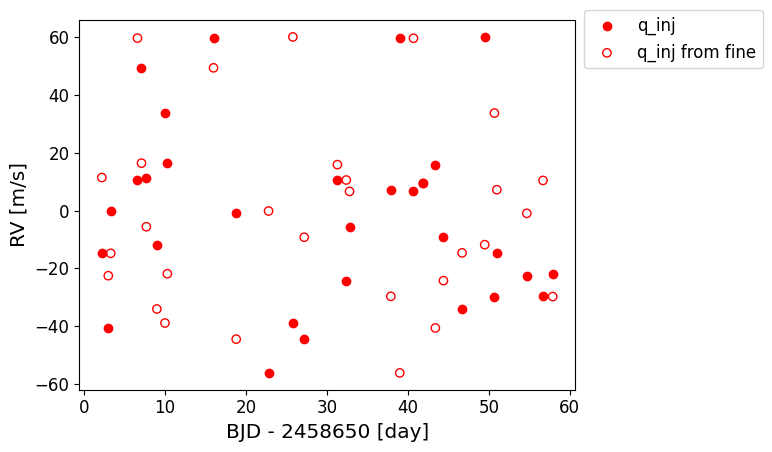

In [13]:
plt.scatter(injected_x, q_inj[1], c='r', label='q_inj')
#plt.scatter(strat, q[1], c='k', label='q')
plt.scatter(validation_inference.x, validation_inference.y, facecolors='none', edgecolors='r', label='q_inj from fine')
#plt.scatter(training_inference.x, training_inference.y, facecolors='none', edgecolors='k', label='q from fine')
#plt.plot(x_fine, fine.y, label='best-fit')
#plt.plot(x_fine, observed_fine[0], label='ground truth')
plt.legend(bbox_to_anchor=(1., 1.05))
plt.xlabel('BJD - 2458650 [day]')
plt.ylabel('RV [m/s]')
plt.show()